# Fluidity Local Model: Creep and Viscosity Bifurcation

**Learning Objectives:**
- Understand creep behavior in yield-stress fluids
- Observe viscosity bifurcation at yield stress: solid-like (σ < τ_y) vs fluid-like (σ > τ_y)
- Fit FluidityLocal model to creep data with NLSQ
- Perform Bayesian inference with NUTS warm-start
- Compare creep responses below and above yield stress

**Prerequisites:** `basic/01_getting_started.ipynb`, `bayesian/01_bayesian_intro.ipynb`

**Runtime:**
- Fast mode (1 chain): ~3-5 min
- Full mode (4 chains): ~10-15 min

## 1. Setup

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import json
import os
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fluidity import FluidityLocal

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {'R2': r2, 'RMSE': rmse}

## 2. Theory: Creep in Yield-Stress Fluids

The Fluidity model describes yield-stress fluids with a scalar fluidity field $f(t)$ that evolves via:

$$\frac{df}{dt} = \frac{f_{eq} - f}{\theta} + a|\dot{\gamma}|^n(f_{\infty} - f)$$

where:
- $f_{eq}$: Equilibrium (low-shear) fluidity
- $f_{\infty}$: High-shear fluidity
- $\theta$: Aging timescale
- $a$: Rejuvenation amplitude
- $n$: Rejuvenation exponent

**Creep Protocol:**
Constant stress $\sigma_{applied}$ is applied, and we track strain evolution:

$$\frac{d\gamma}{dt} = \sigma_{applied} \cdot f(t)$$

**Viscosity Bifurcation:**
- **Below yield** ($\sigma < \tau_y$): Fluidity stays low ($f \approx f_{eq}$), strain saturates → **solid-like**
- **Above yield** ($\sigma > \tau_y$): Fluidity increases ($f \to f_{\infty}$), strain grows indefinitely → **fluid-like**

This bifurcation is the hallmark of yield-stress materials (mucus, pastes, emulsions).

## 3. Generate Synthetic Creep Data

We'll generate creep data at two stress levels:
- **Below yield:** $\sigma/\tau_y = 0.8$ (solid-like)
- **Above yield:** $\sigma/\tau_y = 1.2$ (fluid-like)

In [4]:
# True parameters (calibrated from flow curve)
params_true = {
    "G": 5e5,         # Pa - elastic modulus
    "tau_y": 100.0,   # Pa - yield stress
    "K": 50.0,        # Pa·s^n - flow consistency
    "n_flow": 0.5,    # dimensionless - flow exponent
    "f_eq": 1e-6,     # 1/(Pa·s) - equilibrium fluidity
    "f_inf": 1e-3,    # 1/(Pa·s) - high-shear fluidity
    "theta": 10.0,    # s - aging timescale
    "a": 0.5,         # dimensionless - rejuvenation amplitude
    "n_rejuv": 1.0,   # dimensionless - rejuvenation exponent
}

# Stress levels
sigma_below = 0.8 * params_true["tau_y"]  # 80 Pa
sigma_above = 1.2 * params_true["tau_y"]  # 120 Pa

print(f"Yield stress: {params_true['tau_y']:.1f} Pa")
print(f"Below yield: {sigma_below:.1f} Pa (σ/τ_y = 0.8)")
print(f"Above yield: {sigma_above:.1f} Pa (σ/τ_y = 1.2)")

Yield stress: 100.0 Pa
Below yield: 80.0 Pa (σ/τ_y = 0.8)
Above yield: 120.0 Pa (σ/τ_y = 1.2)


In [5]:
# Generate creep data
model_gen = FluidityLocal()
for key, val in params_true.items():
    model_gen.parameters.set_value(key, val)
model_gen.fitted_ = True
model_gen._test_mode = "creep"

# Time array: logarithmic spacing for transient dynamics
t = np.logspace(-1, 2, 60)  # 0.1 to 100 s

# Simulate below yield
model_gen._sigma_applied = sigma_below
gamma_below_clean = model_gen.predict(t)
gamma_below = gamma_below_clean + 0.01 * np.random.randn(len(t)) * np.max(gamma_below_clean)

# Simulate above yield
model_gen._sigma_applied = sigma_above
gamma_above_clean = model_gen.predict(t)
gamma_above = gamma_above_clean + 0.01 * np.random.randn(len(t)) * np.max(gamma_above_clean)

print(f"Data points: {len(t)}")
print(f"Time range: {t.min():.2f} – {t.max():.1f} s")
print(f"Strain (below): {gamma_below.min():.4f} – {gamma_below.max():.4f}")
print(f"Strain (above): {gamma_above.min():.4f} – {gamma_above.max():.4f}")

Data points: 60
Time range: 0.10 – 100.0 s
Strain (below): -0.0001 – 0.0124
Strain (above): -0.0006 – 0.0257


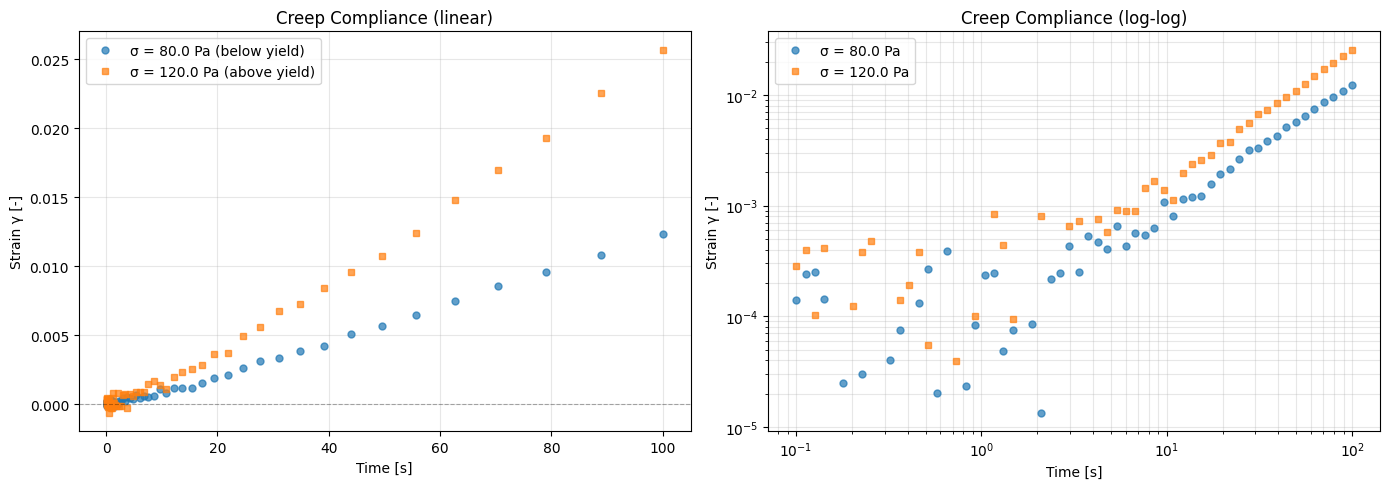

In [6]:
# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1.plot(t, gamma_below, "o", color="C0", markersize=5, alpha=0.7, label=f"σ = {sigma_below:.1f} Pa (below yield)")
ax1.plot(t, gamma_above, "s", color="C1", markersize=5, alpha=0.7, label=f"σ = {sigma_above:.1f} Pa (above yield)")
ax1.axhline(0, color="k", linestyle="--", linewidth=0.8, alpha=0.3)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Strain γ [-]")
ax1.set_title("Creep Compliance (linear)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Log-log scale
ax2.loglog(t, gamma_below, "o", color="C0", markersize=5, alpha=0.7, label=f"σ = {sigma_below:.1f} Pa")
ax2.loglog(t, gamma_above, "s", color="C1", markersize=5, alpha=0.7, label=f"σ = {sigma_above:.1f} Pa")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Strain γ [-]")
ax2.set_title("Creep Compliance (log-log)")
ax2.legend()
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
plt.show()
plt.close('all')

**Observation:**
- Below yield: strain **saturates** (solid-like, elastic response)
- Above yield: strain **grows continuously** (fluid-like, viscous flow)

## 4. NLSQ Fitting: Above Yield

We'll first fit the above-yield data to extract material parameters.

In [7]:
model = FluidityLocal()

t0_fit = time.time()
model.fit(t, gamma_above, test_mode="creep", sigma_applied=sigma_above, method='scipy')

# Compute fit quality
gamma_pred = model.predict(t, test_mode="creep", sigma_applied=sigma_above)
metrics = compute_fit_quality(gamma_above, gamma_pred)
t_nlsq = time.time() - t0_fit

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4g}")
print("\nFitted parameters:")
for name in ["G", "tau_y", "K", "n_flow", "f_eq", "f_inf", "theta", "a", "n_rejuv"]:
    val = model.parameters.get_value(name)
    true_val = params_true[name]
    error = 100 * abs(val - true_val) / true_val
    print(f"  {name:8s} = {val:9.4g}  (true: {true_val:9.4g}, error: {error:5.1f}%)")

NLSQ fit time: 10.03 s
R²: -2.766290
RMSE: 0.01138

Fitted parameters:
  G        =     1e+06  (true:     5e+05, error: 100.0%)
  tau_y    =      1000  (true:       100, error: 900.0%)
  K        =      1000  (true:        50, error: 1900.0%)
  n_flow   =       0.5  (true:       0.5, error:   0.0%)
  f_eq     = 5.568e-07  (true:     1e-06, error:  44.3%)
  f_inf    = 0.0009988  (true:     0.001, error:   0.1%)
  theta    =        10  (true:        10, error:   0.0%)
  a        =         1  (true:       0.5, error: 100.0%)
  n_rejuv  =         1  (true:         1, error:   0.0%)


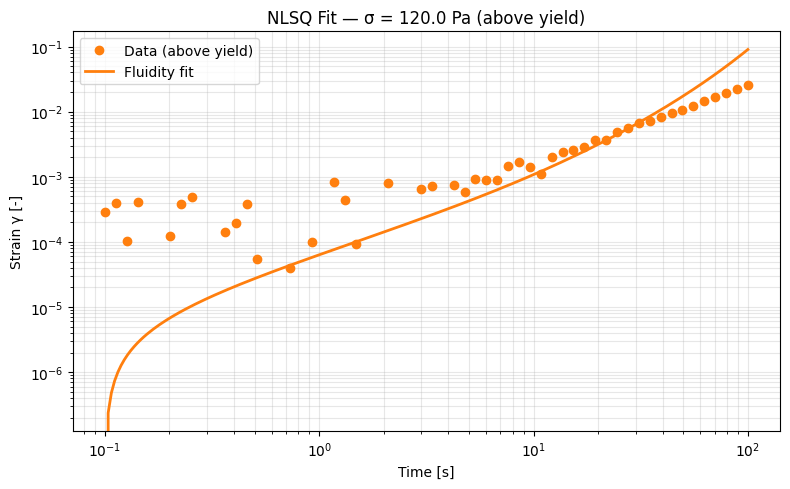

In [8]:
# Predict with fitted model
t_fine = np.logspace(np.log10(t.min()), np.log10(t.max()), 200)
model._sigma_applied = sigma_above
gamma_pred = model.predict(t_fine)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(t, gamma_above, "o", color="C1", markersize=6, label="Data (above yield)")
ax.loglog(t_fine, gamma_pred, "-", lw=2, color="C1", label="Fluidity fit")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Strain γ [-]")
ax.set_title(f"NLSQ Fit — σ = {sigma_above:.1f} Pa (above yield)")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
plt.show()
plt.close('all')

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

In [9]:
initial_values = {name: model.parameters.get_value(name) for name in model.parameters.keys()}
print("Warm-start values (first 5):")
for i, (k, v) in enumerate(initial_values.items()):
    if i < 5:
        print(f"  {k}: {v:.4g}")

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.time()
result = model.fit_bayesian(
    t, gamma_above, test_mode="creep", sigma_applied=sigma_above,
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values (first 5):
  G: 1e+06
  tau_y: 1000
  K: 1000
  n_flow: 0.5
  f_eq: 5.568e-07


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:03<35:22,  3.04s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   2%|▏         | 17/700 [00:03<01:41,  6.72it/s, 1023 steps of size 8.32e-05. acc. prob=0.76]

warmup:   3%|▎         | 20/700 [00:04<01:55,  5.89it/s, 1023 steps of size 1.20e-04. acc. prob=0.80]

warmup:   3%|▎         | 22/700 [00:04<02:05,  5.41it/s, 1023 steps of size 1.54e-04. acc. prob=0.82]

warmup:   3%|▎         | 24/700 [00:05<02:12,  5.08it/s, 1023 steps of size 1.96e-04. acc. prob=0.83]

warmup:   4%|▎         | 25/700 [00:05<02:20,  4.79it/s, 1023 steps of size 2.21e-04. acc. prob=0.84]

warmup:   4%|▎         | 26/700 [00:05<02:24,  4.65it/s, 1023 steps of size 2.49e-04. acc. prob=0.85]

warmup:   4%|▍         | 27/700 [00:06<02:32,  4.42it/s, 1023 steps of size 2.79e-04. acc. prob=0.85]

warmup:   4%|▍         | 28/700 [00:06<02:40,  4.18it/s, 1023 steps of size 3.07e-04. acc. prob=0.86]

warmup:   4%|▍         | 29/700 [00:06<02:39,  4.21it/s, 1023 steps of size 3.44e-04. acc. prob=0.86]

warmup:   4%|▍         | 30/700 [00:06<02:39,  4.20it/s, 1023 steps of size 3.85e-04. acc. prob=0.87]

warmup:   4%|▍         | 31/700 [00:07<02:46,  4.03it/s, 1023 steps of size 4.28e-04. acc. prob=0.87]

warmup:   5%|▍         | 32/700 [00:07<02:48,  3.96it/s, 1023 steps of size 4.66e-04. acc. prob=0.87]

warmup:   5%|▍         | 33/700 [00:07<02:51,  3.88it/s, 1023 steps of size 5.17e-04. acc. prob=0.88]

warmup:   5%|▍         | 34/700 [00:07<02:46,  3.99it/s, 1023 steps of size 5.52e-04. acc. prob=0.88]

warmup:   5%|▌         | 35/700 [00:08<02:44,  4.03it/s, 1023 steps of size 5.99e-04. acc. prob=0.88]

warmup:   5%|▌         | 36/700 [00:08<02:46,  3.99it/s, 1023 steps of size 6.64e-04. acc. prob=0.89]

warmup:   5%|▌         | 37/700 [00:08<02:43,  4.06it/s, 1023 steps of size 6.42e-04. acc. prob=0.89]

warmup:   5%|▌         | 38/700 [00:08<02:44,  4.02it/s, 1023 steps of size 7.08e-04. acc. prob=0.89]

warmup:   6%|▌         | 39/700 [00:09<02:47,  3.95it/s, 1023 steps of size 7.15e-04. acc. prob=0.89]

warmup:   6%|▌         | 40/700 [00:09<02:53,  3.80it/s, 1023 steps of size 7.77e-04. acc. prob=0.90]

warmup:   6%|▌         | 41/700 [00:09<03:37,  3.02it/s, 1023 steps of size 8.54e-04. acc. prob=0.90]

warmup:   6%|▌         | 42/700 [00:10<03:16,  3.34it/s, 1023 steps of size 9.37e-04. acc. prob=0.90]

warmup:   6%|▌         | 43/700 [00:10<03:06,  3.52it/s, 1023 steps of size 1.00e-03. acc. prob=0.90]

warmup:   6%|▋         | 44/700 [00:10<03:00,  3.64it/s, 1023 steps of size 1.00e-03. acc. prob=0.90]

warmup:   6%|▋         | 45/700 [00:10<02:58,  3.67it/s, 1023 steps of size 1.09e-03. acc. prob=0.91]

warmup:   7%|▋         | 46/700 [00:11<02:48,  3.88it/s, 1023 steps of size 1.18e-03. acc. prob=0.91]

warmup:   7%|▋         | 47/700 [00:11<02:43,  4.00it/s, 1023 steps of size 1.22e-03. acc. prob=0.91]

warmup:   7%|▋         | 48/700 [00:11<02:54,  3.73it/s, 1023 steps of size 1.20e-03. acc. prob=0.91]

warmup:   7%|▋         | 49/700 [00:11<02:51,  3.79it/s, 1023 steps of size 9.44e-04. acc. prob=0.91]

warmup:   7%|▋         | 50/700 [00:12<02:46,  3.92it/s, 1023 steps of size 8.95e-04. acc. prob=0.91]

warmup:   7%|▋         | 51/700 [00:12<02:43,  3.98it/s, 1023 steps of size 9.70e-04. acc. prob=0.91]

warmup:   7%|▋         | 52/700 [00:12<02:47,  3.88it/s, 1023 steps of size 1.05e-03. acc. prob=0.91]

warmup:   8%|▊         | 53/700 [00:12<02:43,  3.97it/s, 1023 steps of size 1.09e-03. acc. prob=0.92]

warmup:   8%|▊         | 54/700 [00:13<02:54,  3.70it/s, 1023 steps of size 1.09e-03. acc. prob=0.92]

warmup:   8%|▊         | 55/700 [00:13<02:56,  3.65it/s, 1023 steps of size 1.17e-03. acc. prob=0.92]

warmup:   8%|▊         | 56/700 [00:13<02:47,  3.86it/s, 1023 steps of size 1.25e-03. acc. prob=0.92]

warmup:   8%|▊         | 57/700 [00:13<02:41,  3.98it/s, 1023 steps of size 1.33e-03. acc. prob=0.92]

warmup:   8%|▊         | 58/700 [00:14<02:27,  4.36it/s, 769 steps of size 1.33e-03. acc. prob=0.92] 

warmup:   8%|▊         | 59/700 [00:14<02:26,  4.38it/s, 1023 steps of size 1.29e-03. acc. prob=0.92]

warmup:   9%|▊         | 60/700 [00:14<02:28,  4.32it/s, 1023 steps of size 2.63e-04. acc. prob=0.91]

warmup:   9%|▊         | 61/700 [00:14<02:39,  4.00it/s, 1023 steps of size 2.86e-04. acc. prob=0.91]

warmup:   9%|▉         | 62/700 [00:15<02:49,  3.77it/s, 1023 steps of size 3.06e-04. acc. prob=0.91]

warmup:   9%|▉         | 63/700 [00:15<02:47,  3.80it/s, 1023 steps of size 3.32e-04. acc. prob=0.91]

warmup:   9%|▉         | 64/700 [00:15<02:42,  3.92it/s, 1023 steps of size 3.57e-04. acc. prob=0.92]

warmup:   9%|▉         | 65/700 [00:15<02:42,  3.90it/s, 1023 steps of size 3.86e-04. acc. prob=0.92]

warmup:   9%|▉         | 66/700 [00:16<02:41,  3.92it/s, 1023 steps of size 4.08e-04. acc. prob=0.92]

warmup:  10%|▉         | 67/700 [00:16<02:36,  4.04it/s, 1023 steps of size 4.41e-04. acc. prob=0.92]

warmup:  10%|▉         | 68/700 [00:16<02:36,  4.04it/s, 1023 steps of size 4.72e-04. acc. prob=0.92]

warmup:  10%|▉         | 69/700 [00:16<02:43,  3.86it/s, 1023 steps of size 4.99e-04. acc. prob=0.92]

warmup:  10%|█         | 70/700 [00:17<02:37,  4.01it/s, 1023 steps of size 5.35e-04. acc. prob=0.92]

warmup:  10%|█         | 71/700 [00:17<02:34,  4.07it/s, 1023 steps of size 5.50e-04. acc. prob=0.92]

warmup:  10%|█         | 72/700 [00:17<02:35,  4.05it/s, 1023 steps of size 5.79e-04. acc. prob=0.92]

warmup:  10%|█         | 73/700 [00:17<02:46,  3.76it/s, 1023 steps of size 6.18e-04. acc. prob=0.93]

warmup:  11%|█         | 74/700 [00:18<02:37,  3.97it/s, 1023 steps of size 6.52e-04. acc. prob=0.93]

warmup:  11%|█         | 75/700 [00:18<02:31,  4.13it/s, 1023 steps of size 6.97e-04. acc. prob=0.93]

warmup:  11%|█         | 76/700 [00:18<02:26,  4.26it/s, 1023 steps of size 7.46e-04. acc. prob=0.93]

warmup:  11%|█         | 77/700 [00:18<02:29,  4.17it/s, 1023 steps of size 7.98e-04. acc. prob=0.93]

warmup:  11%|█         | 78/700 [00:19<02:24,  4.30it/s, 1023 steps of size 8.52e-04. acc. prob=0.93]

warmup:  11%|█▏        | 79/700 [00:19<02:23,  4.33it/s, 1023 steps of size 9.00e-04. acc. prob=0.93]

warmup:  11%|█▏        | 80/700 [00:19<02:21,  4.39it/s, 1023 steps of size 9.60e-04. acc. prob=0.93]

warmup:  12%|█▏        | 81/700 [00:19<02:22,  4.34it/s, 1023 steps of size 1.01e-03. acc. prob=0.93]

warmup:  12%|█▏        | 82/700 [00:19<02:24,  4.29it/s, 1023 steps of size 1.07e-03. acc. prob=0.93]

warmup:  12%|█▏        | 83/700 [00:20<02:24,  4.27it/s, 1023 steps of size 9.69e-04. acc. prob=0.93]

warmup:  12%|█▏        | 84/700 [00:20<02:31,  4.06it/s, 1023 steps of size 1.02e-03. acc. prob=0.93]

warmup:  12%|█▏        | 85/700 [00:20<02:30,  4.09it/s, 1023 steps of size 8.97e-04. acc. prob=0.93]

warmup:  12%|█▏        | 86/700 [00:20<02:27,  4.18it/s, 1023 steps of size 9.49e-04. acc. prob=0.93]

warmup:  12%|█▏        | 87/700 [00:21<02:25,  4.22it/s, 1023 steps of size 1.00e-03. acc. prob=0.93]

warmup:  13%|█▎        | 88/700 [00:21<02:27,  4.15it/s, 1023 steps of size 9.74e-04. acc. prob=0.94]

warmup:  13%|█▎        | 89/700 [00:21<02:46,  3.66it/s, 1023 steps of size 6.61e-04. acc. prob=0.93]

warmup:  13%|█▎        | 90/700 [00:22<02:41,  3.78it/s, 1023 steps of size 6.99e-04. acc. prob=0.93]

warmup:  13%|█▎        | 91/700 [00:22<02:42,  3.74it/s, 1023 steps of size 7.40e-04. acc. prob=0.93]

warmup:  13%|█▎        | 92/700 [00:22<02:38,  3.84it/s, 1023 steps of size 6.75e-04. acc. prob=0.93]

warmup:  13%|█▎        | 93/700 [00:22<02:39,  3.80it/s, 1023 steps of size 6.08e-04. acc. prob=0.93]

warmup:  13%|█▎        | 94/700 [00:23<02:34,  3.93it/s, 1023 steps of size 6.32e-04. acc. prob=0.93]

warmup:  14%|█▎        | 95/700 [00:23<02:17,  4.39it/s, 643 steps of size 5.93e-04. acc. prob=0.93] 

warmup:  14%|█▎        | 96/700 [00:23<02:24,  4.17it/s, 1023 steps of size 4.82e-04. acc. prob=0.93]

warmup:  14%|█▍        | 97/700 [00:23<02:26,  4.11it/s, 1023 steps of size 5.04e-04. acc. prob=0.93]

warmup:  14%|█▍        | 98/700 [00:23<02:25,  4.14it/s, 1023 steps of size 5.30e-04. acc. prob=0.94]

warmup:  14%|█▍        | 99/700 [00:24<02:40,  3.75it/s, 1023 steps of size 5.30e-04. acc. prob=0.94]

warmup:  14%|█▍        | 100/700 [00:24<02:34,  3.89it/s, 1023 steps of size 5.60e-04. acc. prob=0.94]

warmup:  14%|█▍        | 101/700 [00:24<02:28,  4.03it/s, 1023 steps of size 5.68e-03. acc. prob=0.94]

warmup:  15%|█▍        | 103/700 [00:25<02:01,  4.93it/s, 1023 steps of size 7.49e-04. acc. prob=0.93]

warmup:  15%|█▍        | 104/700 [00:25<02:07,  4.66it/s, 1023 steps of size 6.52e-04. acc. prob=0.93]

warmup:  15%|█▌        | 105/700 [00:25<02:10,  4.55it/s, 1023 steps of size 6.11e-04. acc. prob=0.93]

warmup:  15%|█▌        | 106/700 [00:25<02:12,  4.48it/s, 1023 steps of size 5.94e-04. acc. prob=0.93]

warmup:  15%|█▌        | 107/700 [00:26<02:14,  4.39it/s, 1023 steps of size 5.90e-04. acc. prob=0.93]

warmup:  15%|█▌        | 108/700 [00:26<02:15,  4.37it/s, 1023 steps of size 5.95e-04. acc. prob=0.93]

warmup:  16%|█▌        | 109/700 [00:26<02:16,  4.34it/s, 1023 steps of size 6.07e-04. acc. prob=0.93]

warmup:  16%|█▌        | 110/700 [00:26<02:21,  4.17it/s, 1023 steps of size 6.24e-04. acc. prob=0.93]

warmup:  16%|█▌        | 111/700 [00:26<02:21,  4.17it/s, 1023 steps of size 6.40e-04. acc. prob=0.94]

warmup:  16%|█▌        | 112/700 [00:27<02:22,  4.11it/s, 1023 steps of size 6.62e-04. acc. prob=0.94]

warmup:  16%|█▌        | 113/700 [00:27<02:19,  4.19it/s, 1023 steps of size 6.88e-04. acc. prob=0.94]

warmup:  16%|█▋        | 114/700 [00:27<02:25,  4.03it/s, 1023 steps of size 7.10e-04. acc. prob=0.94]

warmup:  16%|█▋        | 115/700 [00:27<02:25,  4.02it/s, 1023 steps of size 7.28e-04. acc. prob=0.94]

warmup:  17%|█▋        | 116/700 [00:28<02:23,  4.06it/s, 1023 steps of size 7.61e-04. acc. prob=0.94]

warmup:  17%|█▋        | 117/700 [00:28<02:24,  4.04it/s, 1023 steps of size 7.84e-04. acc. prob=0.94]

warmup:  17%|█▋        | 118/700 [00:28<02:39,  3.64it/s, 1023 steps of size 8.19e-04. acc. prob=0.94]

warmup:  17%|█▋        | 119/700 [00:29<02:32,  3.80it/s, 1023 steps of size 8.51e-04. acc. prob=0.94]

warmup:  17%|█▋        | 120/700 [00:29<02:28,  3.89it/s, 1023 steps of size 8.89e-04. acc. prob=0.94]

warmup:  17%|█▋        | 121/700 [00:29<02:30,  3.86it/s, 1023 steps of size 9.20e-04. acc. prob=0.94]

warmup:  17%|█▋        | 122/700 [00:29<02:29,  3.87it/s, 1023 steps of size 9.62e-04. acc. prob=0.94]

warmup:  18%|█▊        | 123/700 [00:30<02:21,  4.08it/s, 1023 steps of size 1.01e-03. acc. prob=0.94]

warmup:  18%|█▊        | 124/700 [00:30<02:18,  4.17it/s, 1023 steps of size 1.05e-03. acc. prob=0.94]

warmup:  18%|█▊        | 125/700 [00:30<02:26,  3.93it/s, 1023 steps of size 1.09e-03. acc. prob=0.94]

warmup:  18%|█▊        | 126/700 [00:30<02:25,  3.95it/s, 1023 steps of size 1.13e-03. acc. prob=0.94]

warmup:  18%|█▊        | 127/700 [00:31<02:21,  4.06it/s, 1023 steps of size 1.18e-03. acc. prob=0.94]

warmup:  18%|█▊        | 128/700 [00:31<02:25,  3.92it/s, 1023 steps of size 1.22e-03. acc. prob=0.94]

warmup:  18%|█▊        | 129/700 [00:31<02:21,  4.02it/s, 1023 steps of size 1.27e-03. acc. prob=0.94]

warmup:  19%|█▊        | 130/700 [00:31<02:18,  4.12it/s, 1023 steps of size 1.18e-03. acc. prob=0.94]

warmup:  19%|█▊        | 131/700 [00:32<02:21,  4.03it/s, 1023 steps of size 1.23e-03. acc. prob=0.94]

warmup:  19%|█▉        | 132/700 [00:32<02:23,  3.96it/s, 1023 steps of size 1.28e-03. acc. prob=0.95]

warmup:  19%|█▉        | 133/700 [00:32<02:23,  3.95it/s, 1023 steps of size 1.31e-03. acc. prob=0.95]

warmup:  19%|█▉        | 134/700 [00:32<02:24,  3.92it/s, 1023 steps of size 1.28e-03. acc. prob=0.95]

warmup:  19%|█▉        | 135/700 [00:33<02:28,  3.80it/s, 1023 steps of size 1.33e-03. acc. prob=0.95]

warmup:  19%|█▉        | 136/700 [00:33<02:26,  3.84it/s, 1023 steps of size 1.38e-03. acc. prob=0.95]

warmup:  20%|█▉        | 137/700 [00:33<02:26,  3.85it/s, 1023 steps of size 1.39e-03. acc. prob=0.95]

warmup:  20%|█▉        | 138/700 [00:33<02:22,  3.94it/s, 1023 steps of size 1.41e-03. acc. prob=0.95]

warmup:  20%|█▉        | 139/700 [00:34<02:23,  3.92it/s, 1023 steps of size 1.36e-03. acc. prob=0.95]

warmup:  20%|██        | 140/700 [00:34<02:29,  3.75it/s, 1023 steps of size 1.41e-03. acc. prob=0.95]

warmup:  20%|██        | 141/700 [00:34<02:33,  3.65it/s, 1023 steps of size 1.43e-03. acc. prob=0.95]

warmup:  20%|██        | 142/700 [00:34<02:34,  3.60it/s, 1023 steps of size 1.48e-03. acc. prob=0.95]

warmup:  20%|██        | 143/700 [00:35<02:31,  3.67it/s, 1023 steps of size 1.53e-03. acc. prob=0.95]

warmup:  21%|██        | 144/700 [00:35<02:28,  3.76it/s, 1023 steps of size 1.54e-03. acc. prob=0.95]

warmup:  21%|██        | 145/700 [00:35<02:25,  3.82it/s, 1023 steps of size 1.58e-03. acc. prob=0.95]

warmup:  21%|██        | 146/700 [00:35<02:19,  3.96it/s, 1023 steps of size 1.58e-03. acc. prob=0.95]

warmup:  21%|██        | 147/700 [00:36<02:19,  3.97it/s, 1023 steps of size 1.60e-03. acc. prob=0.95]

warmup:  21%|██        | 148/700 [00:36<02:16,  4.06it/s, 1023 steps of size 1.63e-03. acc. prob=0.95]

warmup:  21%|██▏       | 149/700 [00:36<02:16,  4.02it/s, 1023 steps of size 1.41e-03. acc. prob=0.95]

warmup:  21%|██▏       | 150/700 [00:36<02:19,  3.95it/s, 1023 steps of size 1.36e-03. acc. prob=0.95]

warmup:  22%|██▏       | 151/700 [00:37<02:15,  4.06it/s, 1023 steps of size 1.37e-02. acc. prob=0.95]

warmup:  22%|██▏       | 153/700 [00:37<01:47,  5.09it/s, 1023 steps of size 9.90e-04. acc. prob=0.94]

warmup:  22%|██▏       | 154/700 [00:37<02:00,  4.54it/s, 1023 steps of size 6.53e-04. acc. prob=0.94]

warmup:  22%|██▏       | 155/700 [00:38<02:04,  4.38it/s, 1023 steps of size 5.86e-04. acc. prob=0.94]

warmup:  22%|██▏       | 156/700 [00:38<02:05,  4.34it/s, 1023 steps of size 5.52e-04. acc. prob=0.94]

warmup:  22%|██▏       | 157/700 [00:38<02:06,  4.31it/s, 1023 steps of size 5.35e-04. acc. prob=0.95]

warmup:  23%|██▎       | 158/700 [00:38<02:04,  4.37it/s, 1023 steps of size 5.13e-04. acc. prob=0.95]

warmup:  23%|██▎       | 159/700 [00:38<02:08,  4.21it/s, 1023 steps of size 5.21e-04. acc. prob=0.95]

warmup:  23%|██▎       | 160/700 [00:39<02:18,  3.90it/s, 1023 steps of size 5.17e-04. acc. prob=0.95]

warmup:  23%|██▎       | 161/700 [00:39<02:17,  3.91it/s, 1023 steps of size 5.35e-04. acc. prob=0.95]

warmup:  23%|██▎       | 162/700 [00:39<02:22,  3.78it/s, 1023 steps of size 5.48e-04. acc. prob=0.95]

warmup:  23%|██▎       | 163/700 [00:40<02:30,  3.56it/s, 1023 steps of size 5.72e-04. acc. prob=0.95]

warmup:  23%|██▎       | 164/700 [00:40<02:22,  3.77it/s, 1023 steps of size 5.38e-04. acc. prob=0.95]

warmup:  24%|██▎       | 165/700 [00:40<02:18,  3.87it/s, 1023 steps of size 5.64e-04. acc. prob=0.95]

warmup:  24%|██▎       | 166/700 [00:40<02:14,  3.98it/s, 1023 steps of size 5.93e-04. acc. prob=0.95]

warmup:  24%|██▍       | 167/700 [00:41<02:17,  3.87it/s, 1023 steps of size 6.13e-04. acc. prob=0.95]

warmup:  24%|██▍       | 168/700 [00:41<02:12,  4.02it/s, 1023 steps of size 6.18e-04. acc. prob=0.95]

warmup:  24%|██▍       | 169/700 [00:41<02:08,  4.13it/s, 1023 steps of size 6.50e-04. acc. prob=0.95]

warmup:  24%|██▍       | 170/700 [00:41<02:04,  4.24it/s, 1023 steps of size 6.69e-04. acc. prob=0.95]

warmup:  24%|██▍       | 171/700 [00:42<02:03,  4.28it/s, 1023 steps of size 6.42e-04. acc. prob=0.95]

warmup:  25%|██▍       | 172/700 [00:42<02:07,  4.14it/s, 1023 steps of size 6.77e-04. acc. prob=0.95]

warmup:  25%|██▍       | 173/700 [00:42<02:03,  4.25it/s, 1023 steps of size 7.04e-04. acc. prob=0.95]

warmup:  25%|██▍       | 174/700 [00:42<02:02,  4.28it/s, 1023 steps of size 7.16e-04. acc. prob=0.95]

warmup:  25%|██▌       | 175/700 [00:42<02:01,  4.32it/s, 1023 steps of size 5.79e-04. acc. prob=0.95]

warmup:  25%|██▌       | 176/700 [00:43<02:03,  4.25it/s, 1023 steps of size 6.08e-04. acc. prob=0.95]

warmup:  25%|██▌       | 177/700 [00:43<02:05,  4.16it/s, 1023 steps of size 6.41e-04. acc. prob=0.95]

warmup:  25%|██▌       | 178/700 [00:43<02:12,  3.94it/s, 1023 steps of size 6.73e-04. acc. prob=0.95]

warmup:  26%|██▌       | 179/700 [00:43<02:11,  3.96it/s, 1023 steps of size 7.10e-04. acc. prob=0.95]

warmup:  26%|██▌       | 180/700 [00:44<02:13,  3.90it/s, 1023 steps of size 7.47e-04. acc. prob=0.95]

warmup:  26%|██▌       | 181/700 [00:44<02:15,  3.83it/s, 1023 steps of size 7.84e-04. acc. prob=0.95]

warmup:  26%|██▌       | 182/700 [00:44<02:10,  3.98it/s, 1023 steps of size 8.18e-04. acc. prob=0.95]

warmup:  26%|██▌       | 183/700 [00:44<02:10,  3.97it/s, 1023 steps of size 8.38e-04. acc. prob=0.95]

warmup:  26%|██▋       | 184/700 [00:45<02:07,  4.05it/s, 1023 steps of size 8.76e-04. acc. prob=0.95]

warmup:  26%|██▋       | 185/700 [00:45<02:04,  4.15it/s, 1023 steps of size 9.19e-04. acc. prob=0.95]

warmup:  27%|██▋       | 186/700 [00:45<02:07,  4.03it/s, 1023 steps of size 9.21e-04. acc. prob=0.95]

warmup:  27%|██▋       | 187/700 [00:45<02:08,  3.98it/s, 1023 steps of size 9.57e-04. acc. prob=0.95]

warmup:  27%|██▋       | 188/700 [00:46<02:07,  4.01it/s, 1023 steps of size 1.00e-03. acc. prob=0.95]

warmup:  27%|██▋       | 189/700 [00:46<02:05,  4.09it/s, 1023 steps of size 9.94e-04. acc. prob=0.95]

warmup:  27%|██▋       | 190/700 [00:46<02:05,  4.08it/s, 1023 steps of size 1.03e-03. acc. prob=0.95]

warmup:  27%|██▋       | 191/700 [00:46<02:05,  4.05it/s, 1023 steps of size 1.08e-03. acc. prob=0.95]

warmup:  27%|██▋       | 192/700 [00:47<02:04,  4.07it/s, 1023 steps of size 1.12e-03. acc. prob=0.95]

warmup:  28%|██▊       | 193/700 [00:47<02:01,  4.17it/s, 1023 steps of size 1.17e-03. acc. prob=0.95]

warmup:  28%|██▊       | 194/700 [00:47<01:59,  4.23it/s, 1023 steps of size 1.22e-03. acc. prob=0.95]

warmup:  28%|██▊       | 195/700 [00:47<02:00,  4.21it/s, 1023 steps of size 1.07e-03. acc. prob=0.95]

warmup:  28%|██▊       | 196/700 [00:48<01:59,  4.21it/s, 1023 steps of size 1.04e-03. acc. prob=0.95]

warmup:  28%|██▊       | 197/700 [00:48<01:57,  4.28it/s, 1023 steps of size 1.07e-03. acc. prob=0.95]

warmup:  28%|██▊       | 198/700 [00:48<02:00,  4.16it/s, 1023 steps of size 1.11e-03. acc. prob=0.95]

warmup:  28%|██▊       | 199/700 [00:48<02:07,  3.94it/s, 1023 steps of size 1.10e-03. acc. prob=0.95]

warmup:  29%|██▊       | 200/700 [00:49<02:05,  3.98it/s, 1023 steps of size 9.09e-04. acc. prob=0.95]

sample:  29%|██▊       | 201/700 [00:49<02:12,  3.76it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  29%|██▉       | 202/700 [00:49<02:13,  3.74it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  29%|██▉       | 203/700 [00:49<02:08,  3.88it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  29%|██▉       | 204/700 [00:50<02:09,  3.84it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  29%|██▉       | 205/700 [00:50<02:11,  3.76it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  29%|██▉       | 206/700 [00:50<02:07,  3.87it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  30%|██▉       | 207/700 [00:51<02:15,  3.63it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  30%|██▉       | 208/700 [00:51<02:22,  3.46it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  30%|██▉       | 209/700 [00:51<02:15,  3.62it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  30%|███       | 210/700 [00:51<02:22,  3.43it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  30%|███       | 211/700 [00:52<02:16,  3.59it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  30%|███       | 212/700 [00:52<02:19,  3.49it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  31%|███       | 214/700 [00:52<01:53,  4.28it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  31%|███       | 215/700 [00:53<01:53,  4.26it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  31%|███       | 216/700 [00:53<02:01,  3.97it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  31%|███       | 217/700 [00:53<02:03,  3.91it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  31%|███       | 218/700 [00:53<02:01,  3.98it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  31%|███▏      | 219/700 [00:54<01:58,  4.07it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  31%|███▏      | 220/700 [00:54<02:02,  3.92it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  32%|███▏      | 221/700 [00:54<01:58,  4.03it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  32%|███▏      | 222/700 [00:54<02:00,  3.95it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  32%|███▏      | 223/700 [00:55<01:58,  4.02it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  32%|███▏      | 224/700 [00:55<01:56,  4.08it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  32%|███▏      | 225/700 [00:55<01:53,  4.19it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  32%|███▏      | 226/700 [00:55<01:53,  4.19it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  32%|███▏      | 227/700 [00:56<01:52,  4.20it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  33%|███▎      | 228/700 [00:56<01:55,  4.10it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  33%|███▎      | 229/700 [00:56<01:55,  4.08it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  33%|███▎      | 230/700 [00:56<01:55,  4.08it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  33%|███▎      | 231/700 [00:57<01:52,  4.16it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  33%|███▎      | 232/700 [00:57<01:54,  4.09it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  33%|███▎      | 233/700 [00:57<01:52,  4.17it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  33%|███▎      | 234/700 [00:57<02:05,  3.72it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  34%|███▎      | 235/700 [00:58<01:59,  3.88it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  34%|███▎      | 236/700 [00:58<02:01,  3.83it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  34%|███▍      | 237/700 [00:58<02:01,  3.80it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  34%|███▍      | 238/700 [00:59<02:23,  3.22it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  34%|███▍      | 239/700 [00:59<02:24,  3.19it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  34%|███▍      | 240/700 [00:59<02:20,  3.28it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  34%|███▍      | 241/700 [00:59<02:16,  3.37it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  35%|███▍      | 242/700 [01:00<02:04,  3.68it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  35%|███▍      | 243/700 [01:00<02:05,  3.64it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  35%|███▍      | 244/700 [01:00<02:05,  3.64it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  35%|███▌      | 245/700 [01:01<02:08,  3.54it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  35%|███▌      | 246/700 [01:01<02:00,  3.77it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  35%|███▌      | 247/700 [01:01<02:01,  3.72it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  35%|███▌      | 248/700 [01:01<02:03,  3.65it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  36%|███▌      | 249/700 [01:02<02:03,  3.65it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  36%|███▌      | 250/700 [01:02<02:15,  3.32it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  36%|███▌      | 251/700 [01:02<02:05,  3.59it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  36%|███▌      | 252/700 [01:02<02:08,  3.48it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  36%|███▌      | 253/700 [01:03<02:01,  3.67it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  36%|███▋      | 254/700 [01:03<01:57,  3.81it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  36%|███▋      | 255/700 [01:03<01:53,  3.94it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  37%|███▋      | 257/700 [01:04<01:41,  4.35it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  37%|███▋      | 258/700 [01:04<01:42,  4.33it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  37%|███▋      | 259/700 [01:04<01:42,  4.31it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  37%|███▋      | 260/700 [01:04<01:49,  4.01it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  37%|███▋      | 261/700 [01:05<01:46,  4.12it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  37%|███▋      | 262/700 [01:05<01:57,  3.74it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  38%|███▊      | 263/700 [01:05<01:54,  3.82it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  38%|███▊      | 264/700 [01:05<01:59,  3.65it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  38%|███▊      | 265/700 [01:06<01:55,  3.76it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  38%|███▊      | 266/700 [01:06<01:52,  3.86it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  38%|███▊      | 267/700 [01:06<01:49,  3.95it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  38%|███▊      | 268/700 [01:06<01:50,  3.90it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  38%|███▊      | 269/700 [01:07<01:52,  3.84it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  39%|███▊      | 270/700 [01:07<01:49,  3.92it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  39%|███▊      | 271/700 [01:07<01:44,  4.09it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  39%|███▉      | 272/700 [01:07<01:42,  4.18it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  39%|███▉      | 273/700 [01:08<01:47,  3.96it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  39%|███▉      | 274/700 [01:08<01:49,  3.90it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  39%|███▉      | 275/700 [01:08<01:50,  3.86it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  39%|███▉      | 276/700 [01:08<01:48,  3.90it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  40%|███▉      | 277/700 [01:09<01:46,  3.96it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  40%|███▉      | 278/700 [01:09<01:44,  4.04it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  40%|███▉      | 279/700 [01:09<01:47,  3.91it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  40%|████      | 280/700 [01:09<01:43,  4.06it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  40%|████      | 281/700 [01:10<01:42,  4.10it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  40%|████      | 282/700 [01:10<01:46,  3.92it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  40%|████      | 283/700 [01:10<01:43,  4.01it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  41%|████      | 284/700 [01:10<01:49,  3.80it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  41%|████      | 285/700 [01:11<01:48,  3.83it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  41%|████      | 286/700 [01:11<01:47,  3.86it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  41%|████      | 287/700 [01:11<01:56,  3.55it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  41%|████      | 288/700 [01:12<01:48,  3.80it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  41%|████▏     | 289/700 [01:12<01:52,  3.65it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  41%|████▏     | 290/700 [01:12<01:50,  3.70it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  42%|████▏     | 291/700 [01:12<01:50,  3.70it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  42%|████▏     | 292/700 [01:13<01:44,  3.92it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  42%|████▏     | 293/700 [01:13<01:44,  3.91it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  42%|████▏     | 294/700 [01:13<01:42,  3.95it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  42%|████▏     | 295/700 [01:13<01:44,  3.87it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  42%|████▏     | 296/700 [01:14<01:46,  3.80it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  42%|████▏     | 297/700 [01:14<01:47,  3.76it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  43%|████▎     | 298/700 [01:14<01:41,  3.95it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  43%|████▎     | 299/700 [01:14<01:38,  4.05it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  43%|████▎     | 300/700 [01:15<01:39,  4.03it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  43%|████▎     | 301/700 [01:15<01:36,  4.12it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  43%|████▎     | 302/700 [01:15<01:35,  4.17it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  43%|████▎     | 303/700 [01:15<01:35,  4.16it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  43%|████▎     | 304/700 [01:16<01:35,  4.16it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  44%|████▎     | 305/700 [01:16<01:35,  4.13it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  44%|████▎     | 306/700 [01:16<01:36,  4.06it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  44%|████▍     | 307/700 [01:16<01:34,  4.17it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  44%|████▍     | 308/700 [01:17<01:49,  3.59it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  44%|████▍     | 309/700 [01:17<01:49,  3.56it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  44%|████▍     | 310/700 [01:17<01:49,  3.56it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  44%|████▍     | 311/700 [01:18<01:48,  3.60it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  45%|████▍     | 312/700 [01:18<01:43,  3.74it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  45%|████▍     | 313/700 [01:18<01:42,  3.78it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  45%|████▍     | 314/700 [01:18<01:38,  3.92it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  45%|████▌     | 315/700 [01:19<01:41,  3.81it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  45%|████▌     | 316/700 [01:19<01:39,  3.84it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  45%|████▌     | 317/700 [01:19<01:38,  3.89it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  45%|████▌     | 318/700 [01:19<01:37,  3.94it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  46%|████▌     | 319/700 [01:20<01:33,  4.07it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  46%|████▌     | 320/700 [01:20<01:37,  3.88it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  46%|████▌     | 321/700 [01:20<01:35,  3.97it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  46%|████▌     | 322/700 [01:20<01:39,  3.78it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  46%|████▌     | 323/700 [01:21<01:39,  3.80it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  46%|████▋     | 324/700 [01:21<01:38,  3.80it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  46%|████▋     | 325/700 [01:21<01:37,  3.85it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  47%|████▋     | 326/700 [01:21<01:36,  3.87it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  47%|████▋     | 327/700 [01:22<01:32,  4.05it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  47%|████▋     | 328/700 [01:22<01:31,  4.07it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  47%|████▋     | 329/700 [01:22<01:29,  4.14it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  47%|████▋     | 330/700 [01:22<01:37,  3.80it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  47%|████▋     | 331/700 [01:23<01:38,  3.76it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  47%|████▋     | 332/700 [01:23<01:36,  3.80it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  48%|████▊     | 333/700 [01:23<01:35,  3.86it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  48%|████▊     | 334/700 [01:23<01:32,  3.97it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  48%|████▊     | 335/700 [01:24<01:37,  3.73it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  48%|████▊     | 336/700 [01:24<01:39,  3.67it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  48%|████▊     | 337/700 [01:24<01:41,  3.59it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  48%|████▊     | 338/700 [01:24<01:34,  3.84it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  48%|████▊     | 339/700 [01:25<01:33,  3.84it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  49%|████▊     | 340/700 [01:25<01:35,  3.76it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  49%|████▊     | 341/700 [01:25<01:31,  3.94it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  49%|████▉     | 342/700 [01:26<01:32,  3.86it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  49%|████▉     | 343/700 [01:26<01:32,  3.87it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  49%|████▉     | 344/700 [01:26<01:30,  3.94it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  49%|████▉     | 345/700 [01:26<01:29,  3.96it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  49%|████▉     | 346/700 [01:27<01:37,  3.65it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  50%|████▉     | 347/700 [01:27<01:30,  3.91it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  50%|████▉     | 348/700 [01:27<01:26,  4.06it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  50%|████▉     | 349/700 [01:27<01:31,  3.84it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  50%|█████     | 350/700 [01:28<01:27,  3.99it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  50%|█████     | 351/700 [01:28<01:34,  3.68it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  50%|█████     | 352/700 [01:28<01:34,  3.69it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  50%|█████     | 353/700 [01:28<01:30,  3.84it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  51%|█████     | 354/700 [01:29<01:29,  3.87it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  51%|█████     | 355/700 [01:29<01:26,  4.01it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  51%|█████     | 356/700 [01:29<01:29,  3.86it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  51%|█████     | 357/700 [01:29<01:25,  4.03it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  51%|█████     | 358/700 [01:30<01:24,  4.06it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  51%|█████▏    | 359/700 [01:30<01:21,  4.17it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  51%|█████▏    | 360/700 [01:30<01:28,  3.85it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  52%|█████▏    | 361/700 [01:30<01:26,  3.91it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  52%|█████▏    | 362/700 [01:31<01:25,  3.93it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  52%|█████▏    | 363/700 [01:31<01:31,  3.69it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  52%|█████▏    | 364/700 [01:31<01:26,  3.90it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  52%|█████▏    | 365/700 [01:31<01:27,  3.83it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  52%|█████▏    | 366/700 [01:32<01:28,  3.76it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  52%|█████▏    | 367/700 [01:32<01:28,  3.75it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  53%|█████▎    | 368/700 [01:32<01:29,  3.71it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  53%|█████▎    | 369/700 [01:33<01:35,  3.45it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  53%|█████▎    | 370/700 [01:33<01:30,  3.66it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  53%|█████▎    | 371/700 [01:33<01:35,  3.45it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  53%|█████▎    | 372/700 [01:33<01:31,  3.58it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  53%|█████▎    | 373/700 [01:34<01:39,  3.28it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  53%|█████▎    | 374/700 [01:34<01:31,  3.56it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  54%|█████▎    | 375/700 [01:34<01:29,  3.64it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  54%|█████▎    | 376/700 [01:35<01:25,  3.80it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  54%|█████▍    | 377/700 [01:35<01:27,  3.70it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  54%|█████▍    | 378/700 [01:35<01:27,  3.68it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  54%|█████▍    | 379/700 [01:35<01:23,  3.83it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  54%|█████▍    | 380/700 [01:36<01:22,  3.90it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  54%|█████▍    | 381/700 [01:36<01:19,  4.04it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  55%|█████▍    | 382/700 [01:36<01:25,  3.72it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  55%|█████▍    | 383/700 [01:36<01:21,  3.88it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  55%|█████▍    | 384/700 [01:37<01:27,  3.62it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  55%|█████▌    | 385/700 [01:37<01:22,  3.83it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  55%|█████▌    | 386/700 [01:37<01:19,  3.94it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  55%|█████▌    | 387/700 [01:37<01:18,  3.99it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  55%|█████▌    | 388/700 [01:38<01:20,  3.86it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  56%|█████▌    | 389/700 [01:38<01:17,  3.99it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  56%|█████▌    | 390/700 [01:38<01:16,  4.06it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  56%|█████▌    | 391/700 [01:38<01:15,  4.11it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  56%|█████▌    | 392/700 [01:39<01:25,  3.59it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  56%|█████▌    | 393/700 [01:39<01:21,  3.77it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  56%|█████▋    | 394/700 [01:39<01:20,  3.81it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  56%|█████▋    | 395/700 [01:39<01:19,  3.85it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  57%|█████▋    | 396/700 [01:40<01:27,  3.47it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  57%|█████▋    | 397/700 [01:40<01:22,  3.68it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  57%|█████▋    | 398/700 [01:40<01:29,  3.38it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  57%|█████▋    | 399/700 [01:41<01:35,  3.16it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  57%|█████▋    | 400/700 [01:41<01:27,  3.44it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  57%|█████▋    | 401/700 [01:41<01:28,  3.36it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  57%|█████▋    | 402/700 [01:42<01:32,  3.24it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  58%|█████▊    | 403/700 [01:42<01:28,  3.37it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  58%|█████▊    | 404/700 [01:42<01:22,  3.57it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  58%|█████▊    | 405/700 [01:42<01:20,  3.67it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  58%|█████▊    | 406/700 [01:43<01:27,  3.34it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  58%|█████▊    | 407/700 [01:43<01:25,  3.43it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  58%|█████▊    | 408/700 [01:43<01:28,  3.31it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  58%|█████▊    | 409/700 [01:44<01:35,  3.04it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  59%|█████▊    | 410/700 [01:44<01:27,  3.32it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  59%|█████▊    | 411/700 [01:44<01:25,  3.37it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  59%|█████▉    | 412/700 [01:45<01:21,  3.54it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  59%|█████▉    | 413/700 [01:45<01:23,  3.43it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  59%|█████▉    | 414/700 [01:45<01:21,  3.51it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  59%|█████▉    | 415/700 [01:45<01:24,  3.38it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  59%|█████▉    | 416/700 [01:46<01:20,  3.52it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  60%|█████▉    | 417/700 [01:46<01:17,  3.67it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  60%|█████▉    | 418/700 [01:46<01:13,  3.84it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  60%|█████▉    | 419/700 [01:46<01:12,  3.90it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  60%|██████    | 420/700 [01:47<01:20,  3.48it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  60%|██████    | 421/700 [01:47<01:15,  3.71it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  60%|██████    | 422/700 [01:47<01:15,  3.68it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  60%|██████    | 423/700 [01:48<01:15,  3.66it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  61%|██████    | 424/700 [01:48<01:18,  3.50it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  61%|██████    | 425/700 [01:48<01:16,  3.61it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  61%|██████    | 426/700 [01:48<01:14,  3.70it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  61%|██████    | 427/700 [01:49<01:17,  3.52it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  61%|██████    | 428/700 [01:49<01:13,  3.68it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  61%|██████▏   | 429/700 [01:49<01:16,  3.54it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  61%|██████▏   | 430/700 [01:49<01:13,  3.69it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  62%|██████▏   | 431/700 [01:50<01:15,  3.55it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  62%|██████▏   | 432/700 [01:50<01:13,  3.67it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  62%|██████▏   | 433/700 [01:50<01:11,  3.72it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  62%|██████▏   | 434/700 [01:51<01:11,  3.73it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  62%|██████▏   | 435/700 [01:51<01:10,  3.74it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  62%|██████▏   | 436/700 [01:51<01:07,  3.90it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  62%|██████▏   | 437/700 [01:51<01:07,  3.87it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  63%|██████▎   | 438/700 [01:52<01:06,  3.97it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  63%|██████▎   | 439/700 [01:52<01:04,  4.06it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  63%|██████▎   | 440/700 [01:52<01:03,  4.12it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  63%|██████▎   | 441/700 [01:52<01:03,  4.07it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  63%|██████▎   | 442/700 [01:53<01:02,  4.10it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  63%|██████▎   | 443/700 [01:53<01:02,  4.08it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  63%|██████▎   | 444/700 [01:53<01:04,  3.96it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  64%|██████▎   | 445/700 [01:53<01:03,  4.03it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  64%|██████▎   | 446/700 [01:54<01:03,  3.98it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  64%|██████▍   | 447/700 [01:54<01:02,  4.07it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  64%|██████▍   | 448/700 [01:54<01:06,  3.80it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  64%|██████▍   | 449/700 [01:54<01:03,  3.97it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  64%|██████▍   | 450/700 [01:55<01:01,  4.04it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  64%|██████▍   | 451/700 [01:55<01:00,  4.12it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  65%|██████▍   | 452/700 [01:55<01:01,  4.05it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  65%|██████▍   | 453/700 [01:55<01:01,  4.00it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  65%|██████▍   | 454/700 [01:56<01:03,  3.85it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  65%|██████▌   | 455/700 [01:56<01:01,  3.97it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  65%|██████▌   | 456/700 [01:56<01:00,  4.02it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  65%|██████▌   | 457/700 [01:56<01:01,  3.96it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  65%|██████▌   | 458/700 [01:57<01:02,  3.87it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  66%|██████▌   | 459/700 [01:57<00:59,  4.07it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  66%|██████▌   | 460/700 [01:57<01:02,  3.85it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  66%|██████▌   | 461/700 [01:57<00:59,  4.01it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  66%|██████▌   | 462/700 [01:58<01:03,  3.77it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  66%|██████▌   | 463/700 [01:58<01:00,  3.92it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  66%|██████▋   | 464/700 [01:58<00:58,  4.02it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  66%|██████▋   | 465/700 [01:59<01:11,  3.27it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  67%|██████▋   | 466/700 [01:59<01:14,  3.15it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  67%|██████▋   | 467/700 [01:59<01:16,  3.04it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  67%|██████▋   | 468/700 [02:00<01:30,  2.57it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  67%|██████▋   | 469/700 [02:00<01:28,  2.62it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  67%|██████▋   | 470/700 [02:01<01:32,  2.48it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  67%|██████▋   | 471/700 [02:01<01:29,  2.57it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  67%|██████▋   | 472/700 [02:01<01:18,  2.92it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  68%|██████▊   | 473/700 [02:01<01:14,  3.04it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  68%|██████▊   | 474/700 [02:02<01:07,  3.33it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  68%|██████▊   | 475/700 [02:02<01:09,  3.26it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  68%|██████▊   | 476/700 [02:02<01:04,  3.49it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  68%|██████▊   | 477/700 [02:02<01:02,  3.58it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  68%|██████▊   | 478/700 [02:03<00:59,  3.73it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  68%|██████▊   | 479/700 [02:03<01:00,  3.64it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  69%|██████▊   | 480/700 [02:03<01:04,  3.40it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  69%|██████▊   | 481/700 [02:04<01:01,  3.59it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  69%|██████▉   | 482/700 [02:04<01:06,  3.29it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  69%|██████▉   | 484/700 [02:04<00:58,  3.68it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  69%|██████▉   | 485/700 [02:05<00:59,  3.63it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  69%|██████▉   | 486/700 [02:05<00:56,  3.77it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  70%|██████▉   | 487/700 [02:05<01:01,  3.47it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  70%|██████▉   | 488/700 [02:06<01:00,  3.51it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  70%|██████▉   | 489/700 [02:06<01:00,  3.51it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  70%|███████   | 490/700 [02:06<01:01,  3.42it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  70%|███████   | 491/700 [02:06<01:00,  3.43it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  70%|███████   | 492/700 [02:07<01:01,  3.41it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  70%|███████   | 493/700 [02:07<00:59,  3.48it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  71%|███████   | 494/700 [02:07<01:01,  3.34it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  71%|███████   | 495/700 [02:08<00:57,  3.56it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  71%|███████   | 496/700 [02:08<00:54,  3.73it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  71%|███████   | 497/700 [02:08<00:57,  3.52it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  71%|███████   | 498/700 [02:08<00:53,  3.74it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  71%|███████▏  | 499/700 [02:09<00:54,  3.68it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  71%|███████▏  | 500/700 [02:09<00:51,  3.85it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  72%|███████▏  | 501/700 [02:09<00:54,  3.64it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  72%|███████▏  | 502/700 [02:09<00:52,  3.79it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  72%|███████▏  | 503/700 [02:10<00:54,  3.63it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  72%|███████▏  | 504/700 [02:10<00:52,  3.77it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  72%|███████▏  | 505/700 [02:10<00:50,  3.89it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  72%|███████▏  | 506/700 [02:10<00:48,  4.00it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  72%|███████▏  | 507/700 [02:11<00:51,  3.75it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  73%|███████▎  | 508/700 [02:11<00:49,  3.92it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  73%|███████▎  | 509/700 [02:11<00:47,  4.03it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  73%|███████▎  | 510/700 [02:11<00:46,  4.10it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  73%|███████▎  | 511/700 [02:12<00:45,  4.16it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  73%|███████▎  | 512/700 [02:12<00:49,  3.84it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  73%|███████▎  | 513/700 [02:12<00:46,  4.01it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  73%|███████▎  | 514/700 [02:12<00:45,  4.06it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  74%|███████▎  | 515/700 [02:13<00:45,  4.07it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  74%|███████▎  | 516/700 [02:13<00:55,  3.33it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  74%|███████▍  | 517/700 [02:13<00:52,  3.52it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  74%|███████▍  | 518/700 [02:14<00:48,  3.72it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  74%|███████▍  | 519/700 [02:14<00:47,  3.78it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  74%|███████▍  | 520/700 [02:14<00:47,  3.81it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  74%|███████▍  | 521/700 [02:14<00:45,  3.89it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  75%|███████▍  | 522/700 [02:15<00:43,  4.06it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  75%|███████▍  | 523/700 [02:15<00:44,  3.99it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  75%|███████▍  | 524/700 [02:15<00:42,  4.13it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  75%|███████▌  | 525/700 [02:15<00:43,  3.99it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  75%|███████▌  | 526/700 [02:16<00:42,  4.14it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  75%|███████▌  | 527/700 [02:16<00:42,  4.07it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  75%|███████▌  | 528/700 [02:16<00:41,  4.15it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  76%|███████▌  | 529/700 [02:16<00:41,  4.09it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  76%|███████▌  | 530/700 [02:17<00:43,  3.88it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  76%|███████▌  | 531/700 [02:17<00:44,  3.79it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  76%|███████▌  | 532/700 [02:17<00:42,  3.97it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  76%|███████▌  | 533/700 [02:17<00:43,  3.81it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  76%|███████▋  | 534/700 [02:18<00:42,  3.93it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  76%|███████▋  | 535/700 [02:18<00:41,  3.99it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  77%|███████▋  | 536/700 [02:18<00:43,  3.77it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  77%|███████▋  | 537/700 [02:18<00:42,  3.87it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  77%|███████▋  | 538/700 [02:19<00:41,  3.90it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  77%|███████▋  | 539/700 [02:19<00:39,  4.06it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  77%|███████▋  | 540/700 [02:19<00:42,  3.79it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  77%|███████▋  | 541/700 [02:19<00:40,  3.92it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  77%|███████▋  | 542/700 [02:20<00:39,  3.97it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  78%|███████▊  | 543/700 [02:20<00:38,  4.13it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  78%|███████▊  | 544/700 [02:20<00:39,  3.94it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  78%|███████▊  | 545/700 [02:21<00:47,  3.28it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  78%|███████▊  | 546/700 [02:21<00:48,  3.16it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  78%|███████▊  | 547/700 [02:21<00:49,  3.07it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  78%|███████▊  | 548/700 [02:22<00:50,  3.03it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  78%|███████▊  | 549/700 [02:22<00:45,  3.31it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  79%|███████▊  | 550/700 [02:22<00:47,  3.16it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  79%|███████▊  | 551/700 [02:22<00:43,  3.43it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  79%|███████▉  | 552/700 [02:23<00:40,  3.68it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  79%|███████▉  | 553/700 [02:23<00:41,  3.56it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  79%|███████▉  | 554/700 [02:23<00:38,  3.80it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  79%|███████▉  | 555/700 [02:23<00:39,  3.71it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  79%|███████▉  | 556/700 [02:24<00:36,  3.90it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  80%|███████▉  | 557/700 [02:24<00:37,  3.80it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  80%|███████▉  | 558/700 [02:24<00:36,  3.88it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  80%|███████▉  | 559/700 [02:24<00:36,  3.85it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  80%|████████  | 560/700 [02:25<00:35,  3.94it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  80%|████████  | 561/700 [02:25<00:34,  4.03it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  80%|████████  | 562/700 [02:25<00:35,  3.84it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  80%|████████  | 563/700 [02:25<00:34,  3.94it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  81%|████████  | 564/700 [02:26<00:35,  3.83it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  81%|████████  | 565/700 [02:26<00:33,  3.98it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  81%|████████  | 566/700 [02:26<00:34,  3.91it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  81%|████████  | 567/700 [02:27<00:33,  3.92it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  81%|████████  | 568/700 [02:27<00:34,  3.88it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  81%|████████▏ | 569/700 [02:27<00:33,  3.95it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  81%|████████▏ | 570/700 [02:27<00:32,  4.06it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  82%|████████▏ | 571/700 [02:28<00:31,  4.08it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  82%|████████▏ | 572/700 [02:28<00:30,  4.20it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  82%|████████▏ | 573/700 [02:28<00:30,  4.10it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  82%|████████▏ | 574/700 [02:28<00:30,  4.14it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  82%|████████▏ | 575/700 [02:29<00:31,  3.91it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  82%|████████▏ | 576/700 [02:29<00:31,  3.98it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  82%|████████▏ | 577/700 [02:29<00:30,  3.98it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  83%|████████▎ | 578/700 [02:29<00:30,  4.02it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  83%|████████▎ | 579/700 [02:29<00:29,  4.07it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  83%|████████▎ | 580/700 [02:30<00:31,  3.86it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  83%|████████▎ | 581/700 [02:30<00:30,  3.96it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  83%|████████▎ | 582/700 [02:30<00:32,  3.67it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  83%|████████▎ | 583/700 [02:31<00:32,  3.58it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  83%|████████▎ | 584/700 [02:31<00:30,  3.75it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  84%|████████▎ | 585/700 [02:31<00:31,  3.62it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  84%|████████▎ | 586/700 [02:31<00:30,  3.80it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  84%|████████▍ | 587/700 [02:32<00:30,  3.65it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  84%|████████▍ | 588/700 [02:32<00:29,  3.75it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  84%|████████▍ | 589/700 [02:32<00:29,  3.82it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  84%|████████▍ | 590/700 [02:33<00:31,  3.52it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  84%|████████▍ | 591/700 [02:33<00:29,  3.71it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  85%|████████▍ | 592/700 [02:33<00:28,  3.79it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  85%|████████▍ | 593/700 [02:33<00:27,  3.91it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  85%|████████▍ | 594/700 [02:34<00:27,  3.90it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  85%|████████▌ | 595/700 [02:34<00:26,  3.96it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  85%|████████▌ | 596/700 [02:34<00:28,  3.62it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  85%|████████▌ | 597/700 [02:34<00:27,  3.77it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  85%|████████▌ | 598/700 [02:35<00:27,  3.76it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  86%|████████▌ | 599/700 [02:35<00:25,  3.89it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  86%|████████▌ | 600/700 [02:35<00:26,  3.77it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  86%|████████▌ | 601/700 [02:35<00:26,  3.77it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  86%|████████▌ | 602/700 [02:36<00:25,  3.88it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  86%|████████▌ | 603/700 [02:36<00:24,  3.90it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  86%|████████▋ | 604/700 [02:36<00:23,  4.02it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  86%|████████▋ | 605/700 [02:36<00:24,  3.88it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  87%|████████▋ | 606/700 [02:37<00:23,  3.98it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  87%|████████▋ | 607/700 [02:37<00:24,  3.78it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  87%|████████▋ | 608/700 [02:37<00:24,  3.81it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  87%|████████▋ | 609/700 [02:37<00:23,  3.88it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  87%|████████▋ | 610/700 [02:38<00:23,  3.84it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  87%|████████▋ | 611/700 [02:38<00:23,  3.72it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  87%|████████▋ | 612/700 [02:38<00:22,  3.90it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  88%|████████▊ | 613/700 [02:38<00:21,  4.05it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  88%|████████▊ | 614/700 [02:39<00:21,  3.98it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  88%|████████▊ | 615/700 [02:39<00:20,  4.13it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  88%|████████▊ | 616/700 [02:39<00:19,  4.23it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  88%|████████▊ | 617/700 [02:39<00:19,  4.26it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  88%|████████▊ | 618/700 [02:40<00:19,  4.27it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  88%|████████▊ | 619/700 [02:40<00:18,  4.29it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  89%|████████▊ | 620/700 [02:40<00:18,  4.33it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  89%|████████▊ | 621/700 [02:40<00:19,  4.07it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  89%|████████▉ | 622/700 [02:41<00:19,  4.08it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  89%|████████▉ | 623/700 [02:41<00:18,  4.12it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  89%|████████▉ | 624/700 [02:41<00:18,  4.01it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  89%|████████▉ | 625/700 [02:41<00:18,  4.11it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  89%|████████▉ | 626/700 [02:42<00:18,  4.09it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  90%|████████▉ | 627/700 [02:42<00:19,  3.81it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  90%|████████▉ | 628/700 [02:42<00:19,  3.66it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  90%|████████▉ | 629/700 [02:42<00:19,  3.72it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  90%|█████████ | 630/700 [02:43<00:18,  3.79it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  90%|█████████ | 631/700 [02:43<00:18,  3.71it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  90%|█████████ | 632/700 [02:43<00:17,  3.80it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  90%|█████████ | 633/700 [02:43<00:18,  3.69it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  91%|█████████ | 634/700 [02:44<00:16,  3.89it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  91%|█████████ | 635/700 [02:44<00:16,  3.99it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  91%|█████████ | 636/700 [02:44<00:15,  4.07it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  91%|█████████ | 637/700 [02:44<00:15,  4.11it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  91%|█████████ | 638/700 [02:45<00:15,  4.10it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  91%|█████████▏| 639/700 [02:45<00:15,  3.85it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  91%|█████████▏| 640/700 [02:45<00:15,  3.98it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  92%|█████████▏| 641/700 [02:45<00:14,  4.02it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  92%|█████████▏| 642/700 [02:46<00:14,  4.03it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  92%|█████████▏| 643/700 [02:46<00:14,  3.80it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  92%|█████████▏| 644/700 [02:46<00:14,  3.96it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  92%|█████████▏| 645/700 [02:46<00:13,  3.93it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  92%|█████████▏| 646/700 [02:47<00:14,  3.78it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  92%|█████████▏| 647/700 [02:47<00:13,  3.80it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  93%|█████████▎| 648/700 [02:47<00:13,  3.96it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  93%|█████████▎| 649/700 [02:47<00:12,  4.09it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  93%|█████████▎| 650/700 [02:48<00:11,  4.19it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  93%|█████████▎| 651/700 [02:48<00:12,  4.06it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  93%|█████████▎| 652/700 [02:48<00:11,  4.03it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  93%|█████████▎| 653/700 [02:48<00:11,  3.96it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  93%|█████████▎| 654/700 [02:49<00:11,  3.88it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  94%|█████████▎| 655/700 [02:49<00:11,  4.00it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  94%|█████████▎| 656/700 [02:49<00:10,  4.11it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  94%|█████████▍| 657/700 [02:49<00:10,  4.22it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  94%|█████████▍| 658/700 [02:50<00:10,  4.06it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  94%|█████████▍| 659/700 [02:50<00:09,  4.10it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  94%|█████████▍| 660/700 [02:50<00:09,  4.11it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  94%|█████████▍| 661/700 [02:50<00:09,  4.23it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  95%|█████████▍| 662/700 [02:51<00:09,  3.99it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  95%|█████████▍| 663/700 [02:51<00:08,  4.12it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  95%|█████████▍| 664/700 [02:51<00:08,  4.09it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  95%|█████████▌| 665/700 [02:51<00:08,  4.00it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  95%|█████████▌| 666/700 [02:52<00:08,  4.03it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  95%|█████████▌| 667/700 [02:52<00:08,  4.08it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  95%|█████████▌| 668/700 [02:52<00:07,  4.18it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  96%|█████████▌| 669/700 [02:52<00:07,  4.23it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  96%|█████████▌| 670/700 [02:53<00:07,  4.06it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  96%|█████████▌| 671/700 [02:53<00:07,  4.12it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  96%|█████████▌| 672/700 [02:53<00:06,  4.03it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  96%|█████████▌| 673/700 [02:53<00:07,  3.86it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  96%|█████████▋| 674/700 [02:54<00:06,  4.01it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  96%|█████████▋| 675/700 [02:54<00:06,  4.15it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  97%|█████████▋| 676/700 [02:54<00:05,  4.22it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  97%|█████████▋| 677/700 [02:54<00:05,  4.22it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  97%|█████████▋| 678/700 [02:55<00:05,  4.30it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  97%|█████████▋| 679/700 [02:55<00:04,  4.32it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  97%|█████████▋| 680/700 [02:55<00:04,  4.38it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  97%|█████████▋| 681/700 [02:55<00:04,  4.15it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  97%|█████████▋| 682/700 [02:55<00:04,  4.12it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  98%|█████████▊| 683/700 [02:56<00:04,  4.20it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  98%|█████████▊| 684/700 [02:56<00:03,  4.06it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  98%|█████████▊| 685/700 [02:56<00:03,  4.17it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  98%|█████████▊| 686/700 [02:56<00:03,  4.23it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  98%|█████████▊| 687/700 [02:57<00:03,  4.26it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  98%|█████████▊| 688/700 [02:57<00:03,  3.98it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  98%|█████████▊| 689/700 [02:57<00:02,  4.08it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  99%|█████████▊| 690/700 [02:57<00:02,  4.13it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  99%|█████████▊| 691/700 [02:58<00:02,  4.00it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  99%|█████████▉| 692/700 [02:58<00:01,  4.10it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  99%|█████████▉| 693/700 [02:58<00:01,  3.99it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  99%|█████████▉| 694/700 [02:59<00:01,  3.48it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  99%|█████████▉| 695/700 [02:59<00:01,  3.65it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample:  99%|█████████▉| 696/700 [02:59<00:01,  3.38it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample: 100%|█████████▉| 697/700 [02:59<00:00,  3.59it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample: 100%|█████████▉| 698/700 [03:00<00:00,  3.76it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample: 100%|█████████▉| 699/700 [03:00<00:00,  3.89it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample: 100%|██████████| 700/700 [03:00<00:00,  4.01it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]

sample: 100%|██████████| 700/700 [03:00<00:00,  3.88it/s, 1023 steps of size 9.09e-04. acc. prob=0.99]


Bayesian inference time: 187.1 s


### 5.2 Convergence Diagnostics

In [10]:
diag = result.diagnostics
param_names = ["G", "tau_y", "K", "f_eq", "f_inf", "theta"]

print("Convergence Diagnostics (key parameters)")
print("=" * 50)
print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 50)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")
n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics (key parameters)
 Parameter     R-hat       ESS
--------------------------------------------------
         G    1.0000       500
     tau_y    1.0000       500
         K    1.0000       500
      f_eq    1.0000       500
     f_inf    1.0000       500
     theta    1.0000       500

Divergences: 0


### 5.3 ArviZ Plots

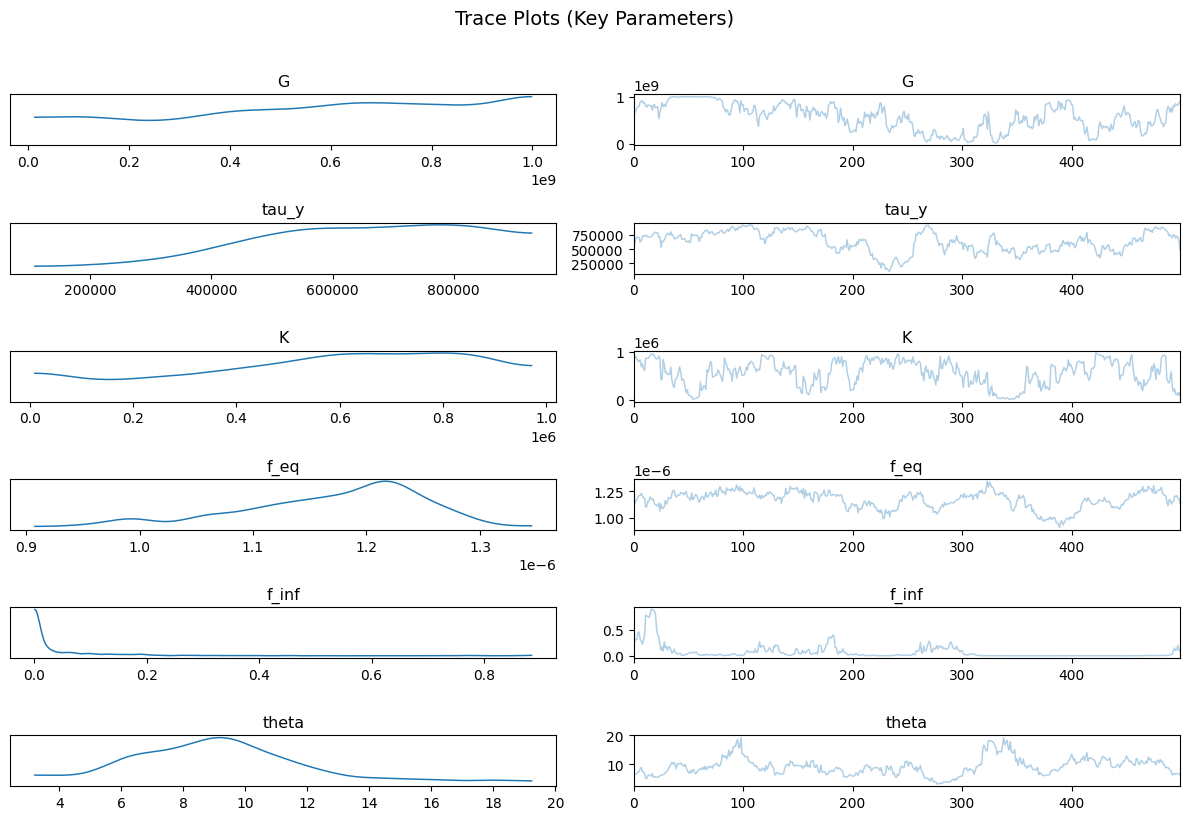

In [11]:
idata = result.to_inference_data()
axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots (Key Parameters)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()
plt.close('all')

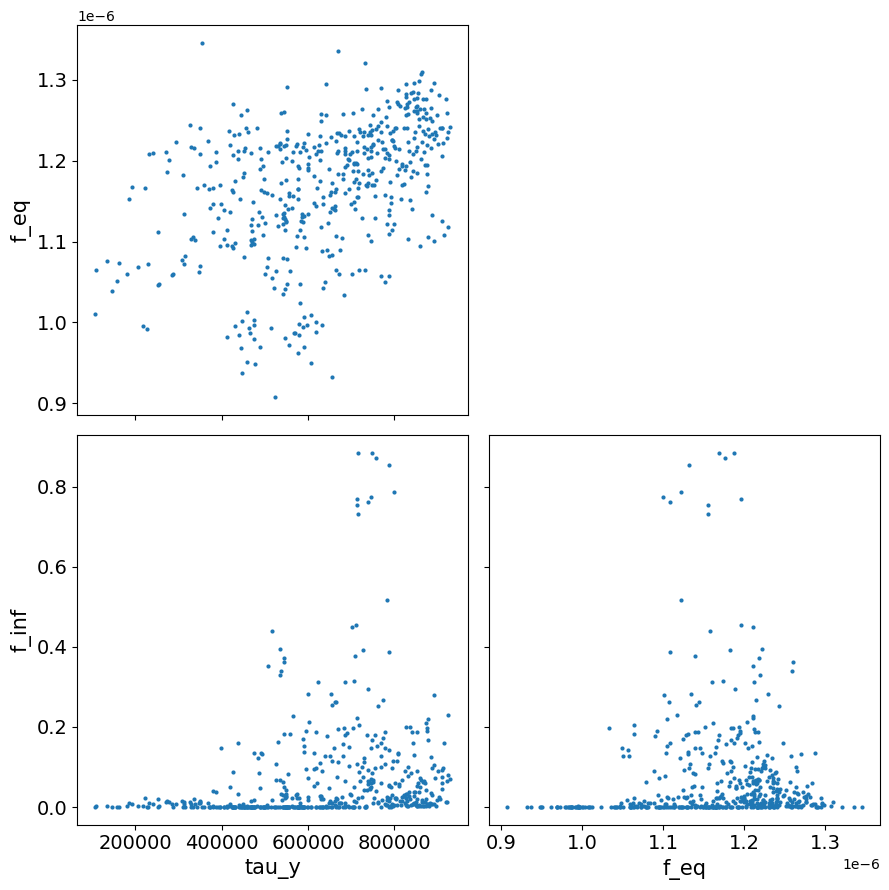

In [12]:
axes = az.plot_pair(idata, var_names=["tau_y", "f_eq", "f_inf"], kind="scatter", divergences=True, figsize=(9, 9))
fig = axes.ravel()[0].figure
plt.tight_layout()
plt.show()
plt.close('all')

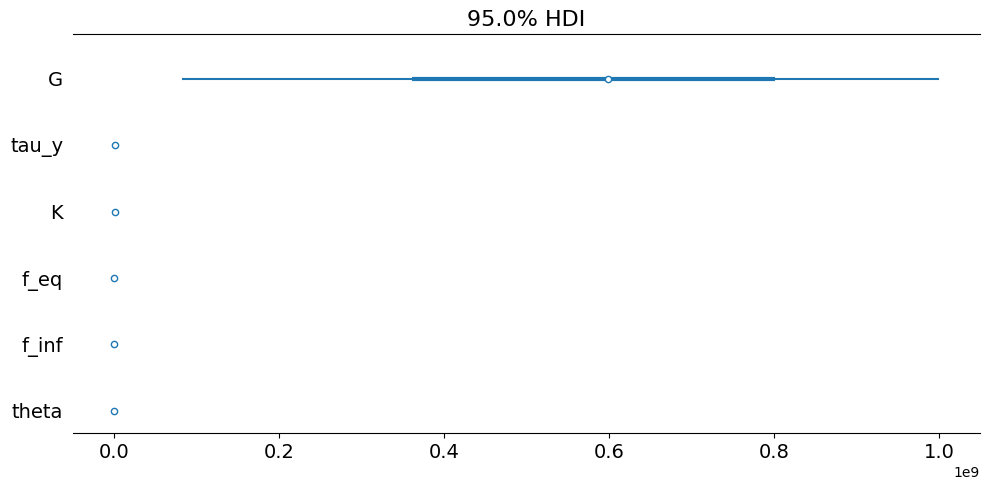

In [13]:
axes = az.plot_forest(idata, var_names=param_names, combined=True, hdi_prob=0.95, figsize=(10, 5))
fig = axes.ravel()[0].figure
plt.tight_layout()
plt.show()
plt.close('all')

### 5.4 Posterior Predictive

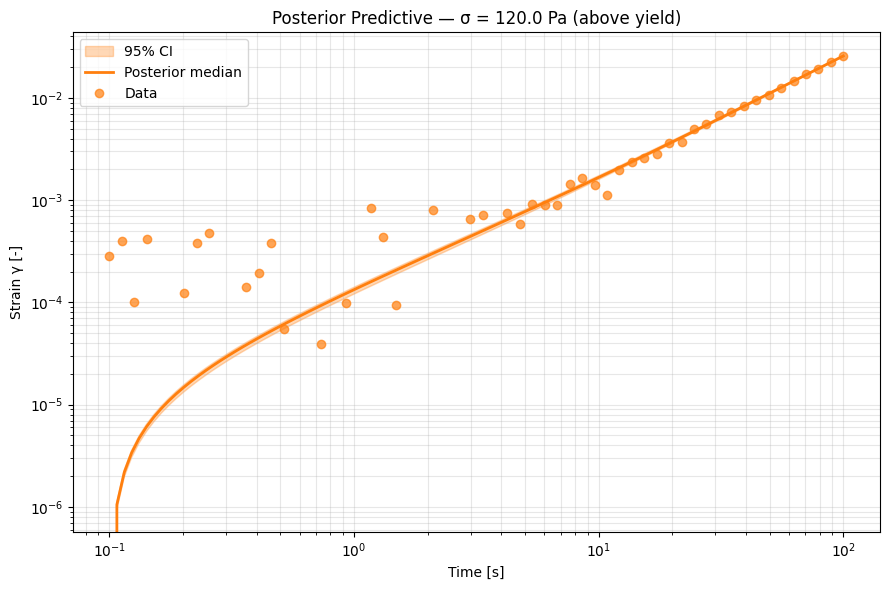

In [14]:
posterior = result.posterior_samples
n_draws = min(200, len(list(posterior.values())[0]))
t_pred = np.logspace(np.log10(t.min()), np.log10(t.max()), 100)

pred_samples = []
param_keys = list(model.parameters.keys())
for i in range(n_draws):
    params_i = jnp.array([posterior[k][i] for k in param_keys])
    # Use model_function with sigma_applied in kwargs
    model._sigma_applied = sigma_above
    pred_i = model.model_function(jnp.array(t_pred), params_i, test_mode="creep")
    pred_samples.append(np.array(pred_i))

pred_samples = np.array(pred_samples)
pred_median = np.median(pred_samples, axis=0)
pred_lo = np.percentile(pred_samples, 2.5, axis=0)
pred_hi = np.percentile(pred_samples, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(9, 6))
ax.fill_between(t_pred, pred_lo, pred_hi, alpha=0.3, color="C1", label="95% CI")
ax.loglog(t_pred, pred_median, "-", lw=2, color="C1", label="Posterior median")
ax.loglog(t, gamma_above, "o", color="C1", markersize=6, alpha=0.7, label="Data")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Strain γ [-]")
ax.set_title(f"Posterior Predictive — σ = {sigma_above:.1f} Pa (above yield)")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
plt.show()
plt.close('all')

## 6. Compare Below vs Above Yield

Now we'll predict creep for both stress levels using the fitted parameters.

In [15]:
# Use NLSQ-fitted parameters for prediction
t_sweep = np.logspace(-1, 2.5, 200)

# Below yield
model._sigma_applied = sigma_below
gamma_below_pred = model.predict(t_sweep)

# Above yield
model._sigma_applied = sigma_above
gamma_above_pred = model.predict(t_sweep)

# Yield stress line (for reference)
model._sigma_applied = params_true["tau_y"]
gamma_yield_pred = model.predict(t_sweep)

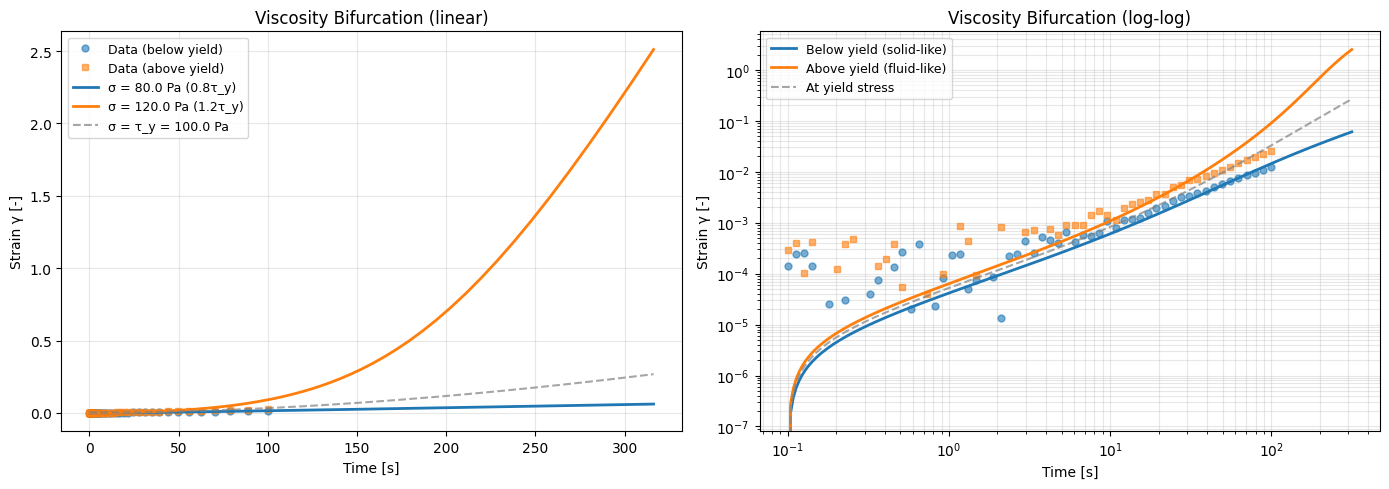

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1.plot(t, gamma_below, "o", color="C0", markersize=5, alpha=0.6, label="Data (below yield)")
ax1.plot(t, gamma_above, "s", color="C1", markersize=5, alpha=0.6, label="Data (above yield)")
ax1.plot(t_sweep, gamma_below_pred, "-", lw=2, color="C0", label=f"σ = {sigma_below:.1f} Pa (0.8τ_y)")
ax1.plot(t_sweep, gamma_above_pred, "-", lw=2, color="C1", label=f"σ = {sigma_above:.1f} Pa (1.2τ_y)")
ax1.plot(t_sweep, gamma_yield_pred, "--", lw=1.5, color="gray", alpha=0.7, label=f"σ = τ_y = {params_true['tau_y']:.1f} Pa")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Strain γ [-]")
ax1.set_title("Viscosity Bifurcation (linear)")
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Log-log scale
ax2.loglog(t, gamma_below, "o", color="C0", markersize=5, alpha=0.6)
ax2.loglog(t, gamma_above, "s", color="C1", markersize=5, alpha=0.6)
ax2.loglog(t_sweep, gamma_below_pred, "-", lw=2, color="C0", label="Below yield (solid-like)")
ax2.loglog(t_sweep, gamma_above_pred, "-", lw=2, color="C1", label="Above yield (fluid-like)")
ax2.loglog(t_sweep, gamma_yield_pred, "--", lw=1.5, color="gray", alpha=0.7, label="At yield stress")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Strain γ [-]")
ax2.set_title("Viscosity Bifurcation (log-log)")
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
plt.show()
plt.close('all')

## 7. Creep Compliance Analysis

Creep compliance: $J(t) = \gamma(t) / \sigma$

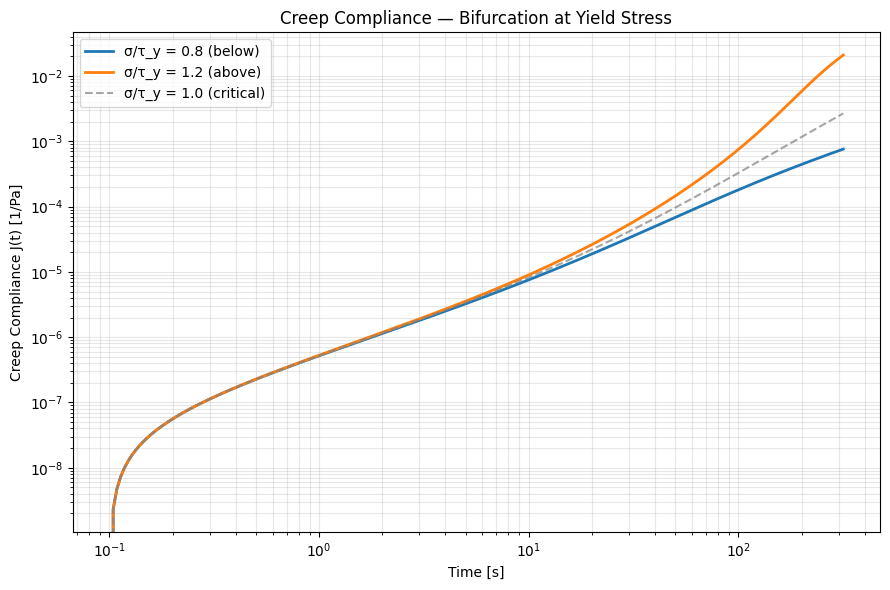

In [17]:
# Compute creep compliance
J_below = gamma_below_pred / sigma_below
J_above = gamma_above_pred / sigma_above
J_yield = gamma_yield_pred / params_true["tau_y"]

fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(t_sweep, J_below, "-", lw=2, color="C0", label=f"σ/τ_y = 0.8 (below)")
ax.loglog(t_sweep, J_above, "-", lw=2, color="C1", label=f"σ/τ_y = 1.2 (above)")
ax.loglog(t_sweep, J_yield, "--", lw=1.5, color="gray", alpha=0.7, label=f"σ/τ_y = 1.0 (critical)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Creep Compliance J(t) [1/Pa]")
ax.set_title("Creep Compliance — Bifurcation at Yield Stress")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
plt.show()
plt.close('all')

**Observation:**
- Below yield: $J(t)$ **plateaus** at long times (elastic solid)
- Above yield: $J(t)$ **grows indefinitely** (viscous fluid)
- At yield: transition regime

## 8. Fluidity Evolution

Extract fluidity evolution $f(t)$ during creep to understand the microscopic mechanism.

In [18]:
# Simulate with trajectory storage (internal state)
from rheojax.models.fluidity._kernels import fluidity_local_creep_ode_rhs
import diffrax

def simulate_with_fluidity(sigma_applied, t_array):
    """Simulate creep and return (strain, fluidity) trajectories."""
    p = model.get_parameter_dict()
    
    args = {
        "sigma_applied": sigma_applied,
        "G": p["G"],
        "f_eq": p["f_eq"],
        "f_inf": p["f_inf"],
        "theta": p["theta"],
        "a": p["a"],
        "n_rejuv": p["n_rejuv"],
    }
    
    y0 = jnp.array([0.0, p["f_eq"]])  # [strain, fluidity]
    
    term = diffrax.ODETerm(lambda ti, yi, args_i: fluidity_local_creep_ode_rhs(ti, yi, args_i))
    solver = diffrax.Tsit5()
    stepsize_controller = diffrax.PIDController(rtol=1e-5, atol=1e-7)
    
    t0 = float(t_array[0])
    t1 = float(t_array[-1])
    dt0 = (t1 - t0) / max(len(t_array), 1000)
    
    saveat = diffrax.SaveAt(ts=jnp.array(t_array, dtype=jnp.float64))
    
    sol = diffrax.diffeqsolve(
        term, solver, t0, t1, dt0, y0,
        args=args, saveat=saveat, stepsize_controller=stepsize_controller,
        max_steps=10_000_000,
    )
    
    return np.array(sol.ys[:, 0]), np.array(sol.ys[:, 1])  # strain, fluidity

gamma_below_full, f_below = simulate_with_fluidity(sigma_below, t_sweep)
gamma_above_full, f_above = simulate_with_fluidity(sigma_above, t_sweep)

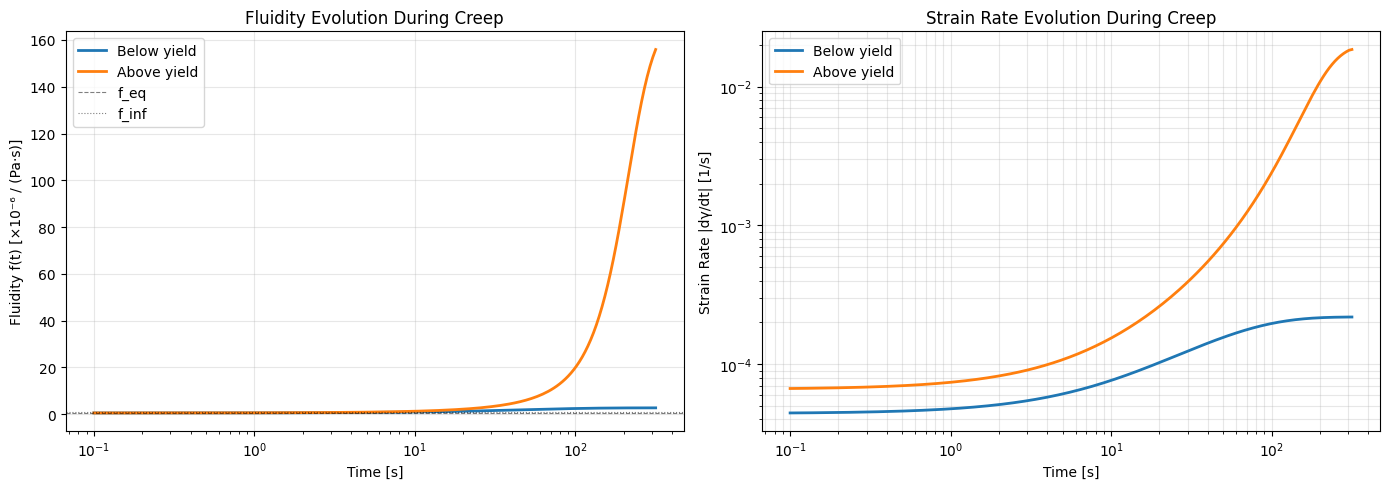

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Fluidity evolution
ax1.semilogx(t_sweep, f_below * 1e6, "-", lw=2, color="C0", label="Below yield")
ax1.semilogx(t_sweep, f_above * 1e6, "-", lw=2, color="C1", label="Above yield")
ax1.axhline(model.parameters.get_value("f_eq") * 1e6, color="k", linestyle="--", linewidth=0.8, alpha=0.5, label="f_eq")
ax1.axhline(model.parameters.get_value("f_inf") * 1e3, color="k", linestyle=":", linewidth=0.8, alpha=0.5, label="f_inf")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Fluidity f(t) [×10⁻⁶ / (Pa·s)]")
ax1.set_title("Fluidity Evolution During Creep")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Strain rate
gamma_dot_below = np.gradient(gamma_below_full, t_sweep)
gamma_dot_above = np.gradient(gamma_above_full, t_sweep)
ax2.loglog(t_sweep, np.abs(gamma_dot_below) + 1e-10, "-", lw=2, color="C0", label="Below yield")
ax2.loglog(t_sweep, np.abs(gamma_dot_above) + 1e-10, "-", lw=2, color="C1", label="Above yield")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Strain Rate |dγ/dt| [1/s]")
ax2.set_title("Strain Rate Evolution During Creep")
ax2.legend()
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
plt.show()
plt.close('all')

**Interpretation:**
- **Below yield:** Fluidity stays near $f_{eq}$ (no rejuvenation), strain rate decays to zero → **solid**
- **Above yield:** Fluidity increases toward $f_{\infty}$ (rejuvenation dominates), strain rate persists → **fluid**

## 9. Save Results

In [20]:
output_dir = os.path.join("..", "outputs", "fluidity", "local", "creep")
os.makedirs(output_dir, exist_ok=True)

# NLSQ parameters
nlsq_params = {name: float(model.parameters.get_value(name)) for name in model.parameters.keys()}
with open(os.path.join(output_dir, "nlsq_params.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Posterior samples
posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_samples.json"), "w") as f:
    json.dump(posterior_dict, f)

# Creep data
creep_data = {
    "time": t.tolist(),
    "sigma_below": float(sigma_below),
    "sigma_above": float(sigma_above),
    "gamma_below": gamma_below.tolist(),
    "gamma_above": gamma_above.tolist(),
}
with open(os.path.join(output_dir, "creep_data.json"), "w") as f:
    json.dump(creep_data, f, indent=2)

print(f"Results saved to {output_dir}/")

Results saved to ../outputs/fluidity/local/creep/


## Key Takeaways

1. **Viscosity bifurcation** is the hallmark of yield-stress fluids:
   - $\sigma < \tau_y$: elastic solid (strain saturates)
   - $\sigma > \tau_y$: viscous fluid (strain grows indefinitely)

2. **Fluidity evolution** encodes the microscopic mechanism:
   - Below yield: $f \approx f_{eq}$ (low fluidity, aging dominates)
   - Above yield: $f \to f_{\infty}$ (high fluidity, rejuvenation dominates)

3. **Bayesian inference** quantifies parameter uncertainty from creep data:
   - NLSQ warm-start is critical for convergence
   - Posterior correlations reveal identifiability challenges (e.g., $f_{eq}$ vs $\theta$)

4. **Creep protocol** is complementary to flow curves and startup:
   - Flow curve: steady-state $\sigma(\dot{\gamma})$
   - Startup: transient $\sigma(t)$ at constant $\dot{\gamma}$
   - Creep: transient $\gamma(t)$ at constant $\sigma$

**Next Steps:**
- NB 01 (flow curve) for steady-state characterization
- NB 02 (startup) for stress overshoot
- NB 04 (SAOS) for linear viscoelasticity
- NB 05 (LAOS) for nonlinear oscillatory response